In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from load_results import load_setup_1, load_setup_2, PARAM_COLUMNS, RESULT_COLUMNS, FITNESS_FUNCTIONS

%matplotlib inline

In [8]:
df = load_setup_1()
df.head()

,fitness_function,use_constraint,constraint_handling_method,constraint,particle_speed_limit,population_size,personal_confidence,swarm_confidence,particle_inertia,constraint_r,fitness,optimum,iterations,optimum_reached,iterations_to_opt
0,Booth's function,False,-,-,13,5,0.5,1.5,0.1,-,0.984780,1.0,500.0,0.000000,9.090909
1,Booth's function,False,-,-,13,5,0.5,1.5,0.5,-,0.998687,1.0,500.0,0.454545,19.090909
2,Booth's function,False,-,-,13,5,0.5,1.5,0.9,-,1.000000,1.0,500.0,1.000000,44.181818
3,Booth's function,False,-,-,13,5,1.0,1.0,0.1,-,0.985024,1.0,500.0,0.000000,13.727273
4,Booth's function,False,-,-,13,5,1.0,1.0,0.5,-,0.998192,1.0,500.0,0.272727,89.818182


In [9]:
df[RESULT_COLUMNS].describe()

,fitness,optimum_reached,iterations_to_opt
count,2052.000000,2052.000000,2052.000000
mean,0.965401,0.548456,38.604824
std,0.070118,0.408992,42.226384
min,0.628848,0.000000,0.625000
25%,0.975026,0.090909,10.500000
50%,0.998936,0.625000,23.414773
75%,1.000000,1.000000,48.967778
max,1.000000,1.000000,288.636364


In [10]:
# inspect values in Experiment setup
for column in PARAM_COLUMNS:
    print(f'{column}: {df[column].unique()}')

fitness_function: ["Booth's function" 'Schwefel function' 'Shubert function']
use_constraint: [False  True]
constraint_handling_method: ['-' 'Penalty Method' 'Rejection Method']
constraint: ['-' 'Constraint 10' 'Constraint 3' 'Constraint 5']
particle_speed_limit: [13]
population_size: [ 5 10 35 80]
personal_confidence: [0.5 1.  1.5]
swarm_confidence: [1.5 1.  0.5]
particle_inertia: [0.1 0.5 0.9]
constraint_r: ['-' -2.0 -1.5 -1.0]


# Evaluation

## Swarm-confidence vs Personal-confidence

### Background

Acceleration coefficions personal confidence and social confidence provied a balance between moving in the direction of the personal best or the direction of the global best

we selected options from 0.5, 1.0 and 1.5 and varied the parameters for high personal influence and low swarm influence, high swarm influence and low personal influence and balanced influence

### Hypothesis

* A weaker swarm coupling decreases convergence speed, because less individuals are in a good area, but also decreases the likelihood of getting caught in local minima

* high personal and low swarm 
    * better local exploration
    * optimum more often found
    * higher iterations because more local search
    * if bad random inizialization stuck in local optimum
* high swarm and low personal
    * better global exploration
    * no early convergence



In [11]:
df_conficence = df[~df.use_constraint].groupby(['fitness_function', 'personal_confidence', 'swarm_confidence'])[RESULT_COLUMNS].mean()
display(df_conficence)

fitness  \
fitness_function  personal_confidence swarm_confidence             
Booth's function  0.5                 1.5               0.998212   
                  1.0                 1.0               0.998253   
                  1.5                 0.5               0.997871   
Schwefel function 0.5                 1.5               0.974086   
                  1.0                 1.0               0.968276   
                  1.5                 0.5               0.955128   
Shubert function  0.5                 1.5               0.887038   
                  1.0                 1.0               0.897150   
                  1.5                 0.5               0.912523   

                                                        optimum_reached  \
fitness_function  personal_confidence swarm_confidence                    
Booth's function  0.5                 1.5                      0.724747   
                  1.0                 1.0                      0.728114   
                  1.5                 0.5                      0.742424   
Schwefel function 0.5                 1.5                      0.714646   
                  1.0                 1.0                      0.636364   
                  1.5                 0.5                      0.516309   
Shubert function  0.5                 1.5                      0.566498   
                  1.0                 1.0                      0.613636   
                  1.5                 0.5                      0.608586   

                                                        iterations_to_opt  
fitness_function  personal_confidence swarm_confidence                     
Booth's function  0.5                 1.5                       16.041035  
                  1.0                 1.0                       24.837963  
                  1.5                 0.5                       30.827125  
Schwefel function 0.5                 1.5                       56.691288  
                  1.0                 1.0                       60.343119  
                  1.5                 0.5                       69.886469  
Shubert function  0.5                 1.5                       15.083018  
                  1.0                 1.0                       27.130471  
                  1.5                 0.5                       70.430240

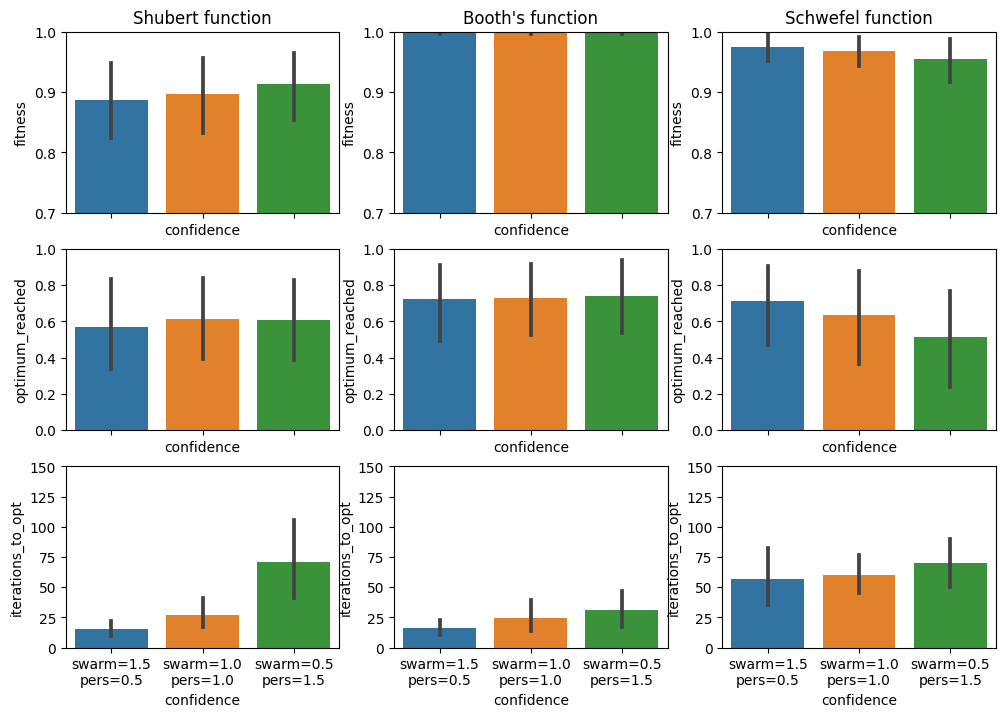

In [12]:
df_conficence = df[~df.use_constraint].reset_index()
df_conficence['confidence'] = df_conficence.apply(lambda row: f'swarm={row.swarm_confidence}\npers={row.personal_confidence}', axis=1)
figure, axes = plt.subplots(3, 3, figsize=(12, 8), sharex=True)
for result_column, axe in zip(RESULT_COLUMNS, axes):
    for fitness_function, ax in zip(FITNESS_FUNCTIONS, axe):
        sns.barplot(
            data=df_conficence[df_conficence.fitness_function == fitness_function],
            x='confidence',
            y=result_column,
            ax=ax)
for ax, fitness_function in zip(axes[0], FITNESS_FUNCTIONS):
    ax.set_ylim(0.7, 1.0)
    ax.set_title(fitness_function)
for ax in axes[1]:
    ax.set_ylim(0.0, 1.0)
for ax in axes[2]:
    ax.set_ylim(0, 150)

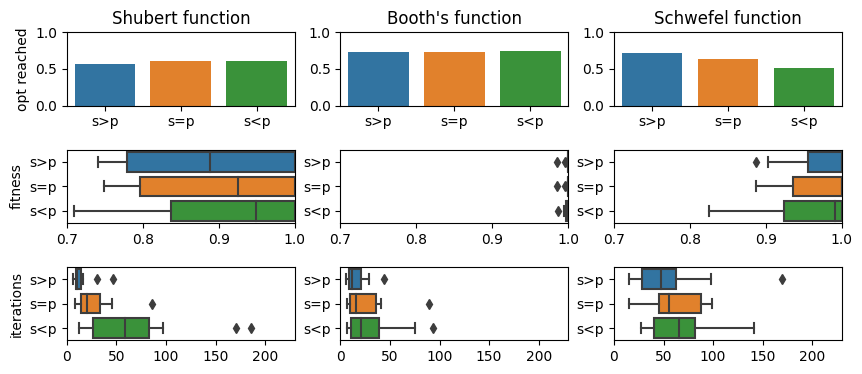

In [16]:
def confidence_txt(row):
    if row.swarm_confidence == 1.5:
        return 's>p'
    if row.personal_confidence == 1.5:
        return 's<p'
    else:
        return 's=p'
df_conficence['confidence'] = df_conficence.apply(confidence_txt, axis=1)

figure, axes = plt.subplots(3, 3, figsize=(10, 4))
plt.subplots_adjust(hspace = 0.6)
for i, fitness_function in enumerate(FITNESS_FUNCTIONS):
    data = df_conficence[df_conficence.fitness_function == fitness_function]
    ax = axes[0][i]
    sns.barplot(
        data=data,
        x='confidence',
        y='optimum_reached',
        errorbar=None,
        ax=ax)
    ax.set_ylim(0.0, 1.0)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_title(fitness_function)

    ax = axes[1][i]
    sns.boxplot(
        data=data,
        x='fitness',
        y='confidence',
        orient='h',
        ax=ax)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_xlim(0.7, 1.0)
    
    ax = axes[2][i]
    sns.boxplot(
        data=data,
        x='iterations_to_opt',
        y='confidence',
        orient='h',
        ax=ax)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_xlim(0, 230)
axes[0][0].set_ylabel('opt reached')
axes[1][0].set_ylabel('fitness')
axes[2][0].set_ylabel('iterations')
plt.savefig('./plots/compare_confidence')

## Shubert function

* the function has very a lot of local optimum and hard to find global optimum -> worst fitness
* clear difference in high personal confidence and low swarm confidence in contrast to high swarm confidence and low personal confidence
* we need more iterations but we find higher fitness -> as we expect 
* higher personal -> more local search
* high swarm -> early convergence in local optimum  -> not as expected -> becaus of function ? 

## Booth's function 

* most of the time near optimumg but optimum only reached 70% of time 
* not much defference in fitness and optimum reached 
* but higher iterations for high pers confidence -> as expected 

## Schwefel function

* many local optima but not so much as in Shubert
* in this case higher swarm confidence better 
* high personal confidence -> early convergence in local optima as expected
